PROYECTO 4: CLASIFICACIÓN DE CALIDAD EN SOLDADURA LÁSER
Dataset generado: 100 registros de soldaduras
Tasa de defectos: 41.0% (41 defectuosas)

Estadísticas descriptivas:
       potencia_laser_w  velocidad_soldadura_mms  temperatura_zona_c  \
count        100.000000               100.000000          100.000000   
mean         136.421689                29.913269          227.640200   
std           35.698729                11.724450           44.013937   
min           80.662654                10.278085          150.759238   
25%          103.184091                19.680181          191.531980   
50%          135.697095                30.224994          234.383240   
75%          167.624374                40.647344          262.855041   
max          198.426432                49.426018          298.508078   

       presion_gas_bar  angulo_incidencia_grados  
count       100.000000                100.000000  
mean          1.727872                 90.481375  
std           0.733631     

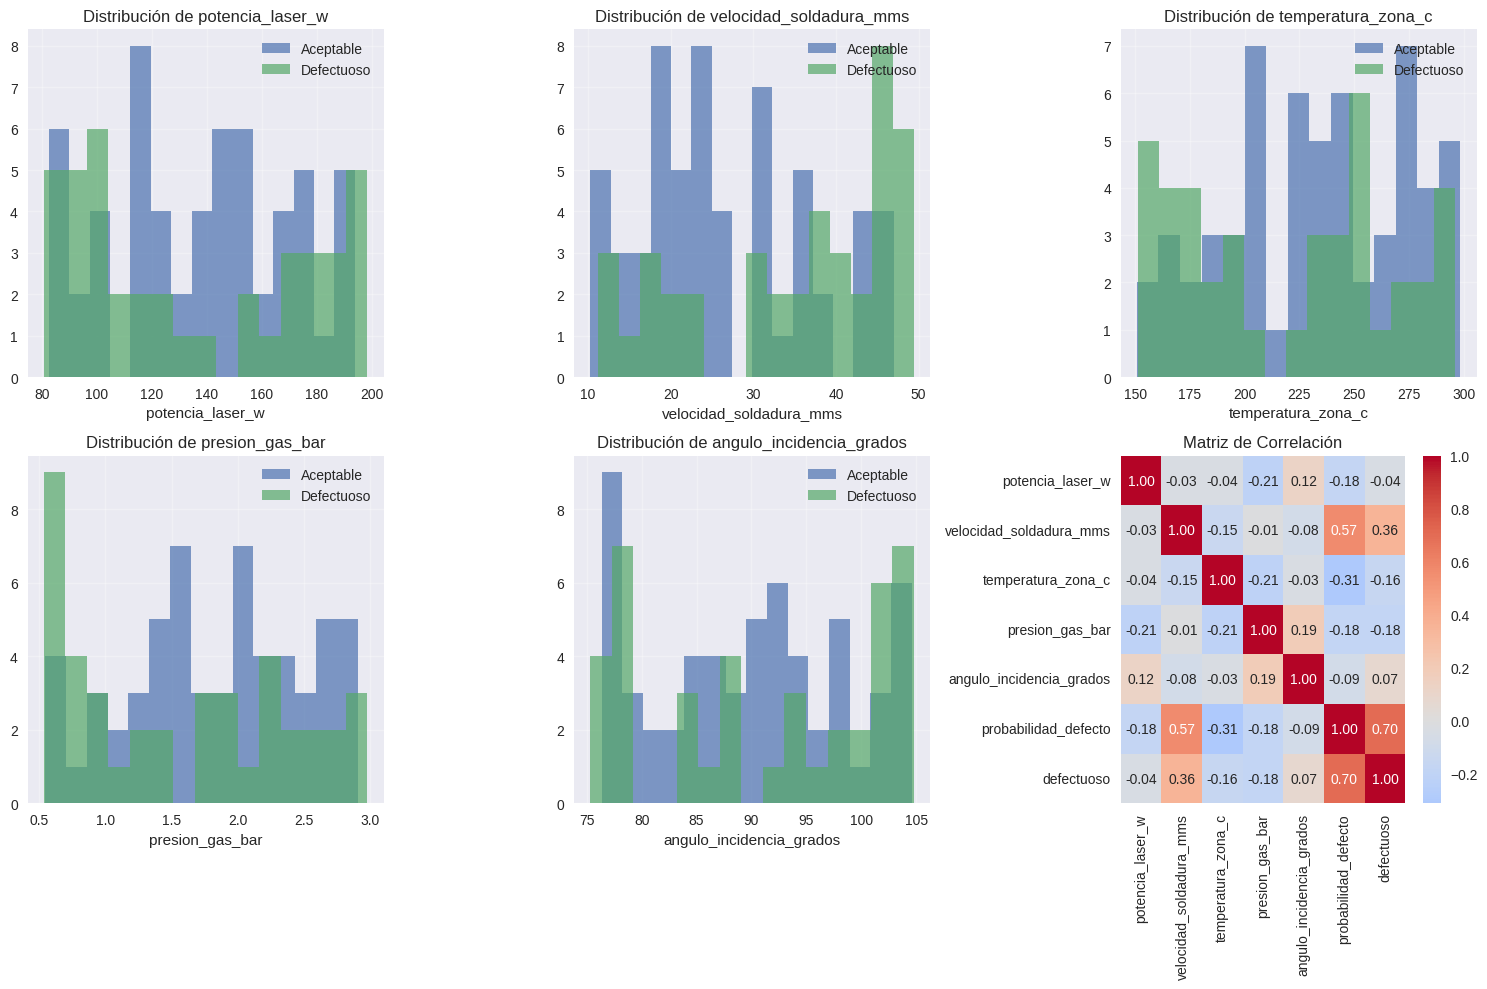


MÉTRICAS DEL MODELO:
Exactitud: 0.640
AUC-ROC: 0.627


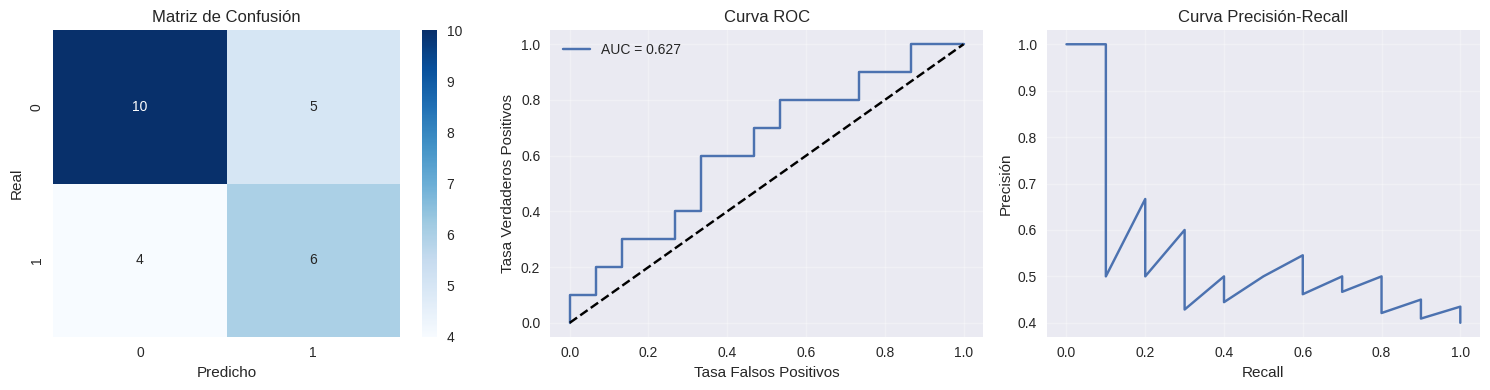


Reporte de Clasificación:
              precision    recall  f1-score   support

   Aceptable       0.71      0.67      0.69        15
  Defectuoso       0.55      0.60      0.57        10

    accuracy                           0.64        25
   macro avg       0.63      0.63      0.63        25
weighted avg       0.65      0.64      0.64        25


ANÁLISIS DE PARÁMETROS CRÍTICOS:
               Parámetro  Coeficiente  Odds_Ratio        Impacto
 velocidad_soldadura_mms     0.606071    1.833215 Aumenta riesgo
angulo_incidencia_grados     0.070784    1.073349 Aumenta riesgo
        potencia_laser_w    -0.062399    0.939508  Reduce riesgo
      temperatura_zona_c    -0.085453    0.918096  Reduce riesgo
         presion_gas_bar    -0.253963    0.775721  Reduce riesgo

CONFIGURACIONES ÓPTIMAS RECOMENDADAS:
• Potencia láser: 120-180 W
• Velocidad soldadura: 20-35 mm/s
• Temperatura zona: 200-260 °C
• Presión gas: 1.5-2.5 bar
• Ángulo incidencia: 85-95 grados

VERIFICACIÓN DE CONFIGURACIO

In [1]:
# PASO 1: Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.preprocessing import StandardScaler

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')
print("PROYECTO 4: CLASIFICACIÓN DE CALIDAD EN SOLDADURA LÁSER")
print("="*60)

# PASO 2: Generación del dataset de ingeniería (100 puntos)
n_samples = 100

# Parámetros del proceso de soldadura láser
potencia_laser = np.random.uniform(80, 200, n_samples)  # Watts
velocidad_soldadura = np.random.uniform(10, 50, n_samples)  # mm/s
temperatura_zona = np.random.uniform(150, 300, n_samples)  # °C
presion_gas = np.random.uniform(0.5, 3.0, n_samples)  # bar
angulo_incidencia = np.random.uniform(75, 105, n_samples)  # grados

# Generar calidad basada en relaciones de ingeniería
probabilidad_defecto = (
    0.3 * (potencia_laser < 100) +                    # Potencia insuficiente
    0.4 * (velocidad_soldadura > 40) +                # Velocidad excesiva
    0.3 * (temperatura_zona < 180) +                  # Temperatura baja
    0.2 * (presion_gas < 1.0) +                       # Presión insuficiente
    0.25 * (abs(angulo_incidencia - 90) > 10) +       # Ángulo incorrecto
    0.35 * (potencia_laser < 110) * (velocidad_soldadura > 35) +
    0.4 * (temperatura_zona < 200) * (presion_gas < 1.2) -
    0.1 * (potencia_laser > 150) * (velocidad_soldadura < 30) +
    np.random.normal(0, 0.15, n_samples)
)

# Asegurar probabilidades entre 0-1 y generar defectos
probabilidad_defecto = np.clip(probabilidad_defecto, 0, 1)
defecto = np.random.binomial(1, probabilidad_defecto)

# Crear DataFrame
data = pd.DataFrame({
    'potencia_laser_w': potencia_laser,
    'velocidad_soldadura_mms': velocidad_soldadura,
    'temperatura_zona_c': temperatura_zona,
    'presion_gas_bar': presion_gas,
    'angulo_incidencia_grados': angulo_incidencia,
    'probabilidad_defecto': probabilidad_defecto,
    'defectuoso': defecto
})

print(f"Dataset generado: {data.shape[0]} registros de soldaduras")
print(f"Tasa de defectos: {defecto.mean():.1%} ({defecto.sum()} defectuosas)")

# PASO 3: Análisis exploratorio rápido
print("\nEstadísticas descriptivas:")
print(data.iloc[:, :-2].describe())

# Visualización compacta
plt.figure(figsize=(15, 10))

# Distribuciones por calidad
variables = ['potencia_laser_w', 'velocidad_soldadura_mms',
            'temperatura_zona_c', 'presion_gas_bar', 'angulo_incidencia_grados']

for i, var in enumerate(variables, 1):
    plt.subplot(2, 3, i)
    plt.hist(data[data['defectuoso'] == 0][var], alpha=0.7, label='Aceptable', bins=15)
    plt.hist(data[data['defectuoso'] == 1][var], alpha=0.7, label='Defectuoso', bins=15)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.legend()
    plt.grid(True, alpha=0.3)

# Matriz de correlación
plt.subplot(2, 3, 6)
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación')

plt.tight_layout()
plt.show()

# PASO 4: Preparación y modelado
X = data[variables]
y = data['defectuoso']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión logística
modelo = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    C=0.1,
    max_iter=1000
)

modelo.fit(X_train_scaled, y_train)

# PASO 5: Evaluación del modelo
y_pred = modelo.predict(X_test_scaled)
y_pred_proba = modelo.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"\nMÉTRICAS DEL MODELO:")
print(f"Exactitud: {accuracy:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")

# Matriz de confusión y curvas
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')

plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa Falsos Positivos')
plt.ylabel('Tasa Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Aceptable', 'Defectuoso']))

# PASO 6: Interpretación para ingeniería
coeficientes = pd.DataFrame({
    'Parámetro': variables,
    'Coeficiente': modelo.coef_[0],
    'Odds_Ratio': np.exp(modelo.coef_[0]),
    'Impacto': ['Aumenta riesgo' if x > 0 else 'Reduce riesgo' for x in modelo.coef_[0]]
}).sort_values('Odds_Ratio', key=abs, ascending=False)

print("\nANÁLISIS DE PARÁMETROS CRÍTICOS:")
print(coeficientes.to_string(index=False))

# PASO 7: Configuraciones óptimas recomendadas
print("\nCONFIGURACIONES ÓPTIMAS RECOMENDADAS:")
print("• Potencia láser: 120-180 W")
print("• Velocidad soldadura: 20-35 mm/s")
print("• Temperatura zona: 200-260 °C")
print("• Presión gas: 1.5-2.5 bar")
print("• Ángulo incidencia: 85-95 grados")

# Validación con casos de prueba
casos_prueba = pd.DataFrame({
    'potencia_laser_w': [120, 180, 90, 160, 200],
    'velocidad_soldadura_mms': [25, 30, 45, 20, 15],
    'temperatura_zona_c': [220, 240, 160, 200, 280],
    'presion_gas_bar': [2.0, 1.8, 0.8, 2.2, 2.5],
    'angulo_incidencia_grados': [90, 88, 105, 92, 85]
})

casos_escalados = scaler.transform(casos_prueba)
probabilidades = modelo.predict_proba(casos_escalados)[:, 1]
decisiones = modelo.predict(casos_escalados)

print("\nVERIFICACIÓN DE CONFIGURACIONES:")
for i, (prob, dec) in enumerate(zip(probabilidades, decisiones)):
    estado = "DEFECTUOSO" if dec == 1 else "ACEPTABLE"
    print(f"Configuración {i+1}: {prob:.1%} probabilidad de defecto → {estado}")

print(f"\nRESUMEN: Modelo de control de calidad para soldadura láser con {accuracy:.1%} de exactitud")
print("y capacidad para identificar parámetros críticos en procesos de manufactura.")